In [6]:
from helper import *
from qpixl import *
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, BasicAer, execute
from qiskit.algorithms.optimizers import COBYLA
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_aer import StatevectorSimulator
from qiskit.providers.aer import QasmSimulator
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
import matplotlib.pyplot as plt

backend = StatevectorSimulator(method="statevector_gpu")


# Quantum Image Processing Project 
This notebook goes through several embedding schemes we have come up with that are either good for simulating (simulator friendly encodings) and NISQ friendly hardware friendly. 
The main feature is that we have implemented an embedding in qiskit for the FRQI-QPIXL framework  (Amankwah et al., May 2022, https://www.nature.com/articles/s41598-022-11024-y ). 
This is included in the ```qpixl.py``` for the full version with compression, and  ```param_qpixl.py``` contains the parameterized version that can be used to generate a NISQ friendly feature map QML.
- Contents
    - Introduction
    - QPIXL
    - Batch Encoding
    - QML 

# Introduction

## Quantum killers
The depth (and connectivity) of a circuit completely determines how well it can be implemented on existing hardware. The killing blow to most
algorithms is that they require fully connected and very deep circuits (which get decomposed to even deeper circuits with limited gatesets). 
Due to non-zero error rates, the probability that at least an error has occured throughout the run of a circuit eventually becomes 1. This can
be mitigated, but at some point it can't be done. This is why short circuits for flexible data embeddings are so important.

## Images in quantum computing
Although quantum computers have a more obvious to see advantage in quantum tasks, nonetheless it is thought that we can see some advantages in tasks involving
classical data loaded onto a quantum computer. Although pictures may not be 'the' data-type that will see an advantage from quantum computing, it is nonetheless 
the case that a lot of data can be input in an image-like format, and studying pictoral algorihtms is definitely way easier on the eyes than pure data-driven tasks! 
Also, with a quantum state representing an image, you can see the results of any quantum transformation of the picture as a new picture! Of course, it needs to be 
seen from many 'angles', but maybe it can help with visualizing what 

# QPIXL

Why do we need another type of embedding in the mix? QPIXL is a framework to decompose popular image encodings such as FRQI, NEQR and their improved counterparts. 
It works by optimally decomposing the gates, and removing any 0 angles that are found. Thanks to the optimal decomposition
the quantum gates can then be further reduced by removing pairs of CNOTS that used to be interweaved by rotation gates. 
They cancel out an become the identity. The code can be seen in the cell below:

In [7]:
def cFRQI(a, compression):
    """    Takes a standard image in a numpy array (so that the matrix looks like
    the image you want if you picture the pixels) and returns the QPIXL
    compressed FRQI circuit. The compression ratio determines
    how many gates will be filtered and then cancelled out. Made into code from this paper:
    https://www.nature.com/articles/s41598-022-11024-y

    Args:
        a (np.array): numpy array of image, must be flattened and padded with zeros up to a power of two
        compression (float): number between 0 an 100, where 0 is no compression and 100 is no image

    Returns:
        QuantumCircuit: qiskit circuit that prepared the encoded image
    """
    a = convertToAngles(a) # convert grayscale to angles
    a = preprocess_image(a) # need to flatten the transpose for easier decoding, 
                            # only really necessary if you want to recover an image.
                            # for classification tasks etc. transpose isn't required.
    n = len(a)
    k = ilog2(n)
    a = 2*a 
    a = sfwht(a)
    a = grayPermutation(a) 
    a_sort_ind = np.argsort(np.abs(a))
    # set smallest absolute values of a to zero according to compression param
    cutoff = int((compression / 100.0) * n)
    for it in a_sort_ind[:cutoff]:
        a[it] = 0
    # print(a)
    # Construct FRQI circuit
    circuit = QuantumCircuit(k + 1)
    # Hadamard register
    circuit.h(range(k))
    # Compressed uniformly controlled rotation register
    ctrl, pc, i = 0, 0, 0
    while i < (2**k):
        # Reset the parity check
        pc = int(0)
        # Add RY gate
        if a[i] != 0:
            circuit.ry(a[i], k)
        # Loop over sequence of consecutive zero angles to 
        # cancel out CNOTS (or rather, to not include them)
        if i == ((2**k) - 1):
            ctrl=0
        else:
            ctrl = grayCode(i) ^ grayCode(i+1)
            ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
        # Update parity check
        pc ^= (2**ctrl)
        i += 1
        while i < (2**k) and a[i] == 0:
            # Compute control qubit
            if i == ((2**k) - 1):
                ctrl=0
            else:
                ctrl = grayCode(i) ^ grayCode(i+1)
                ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
            # Update parity check
            pc ^= (2**ctrl)
            i += 1              
        for j in range(k):
            if (pc >> j)  &  1:
                circuit.cnot(j, k)      
    return circuit.reverse_bits()


This can be used to encode and see images! But to do this, you need to use the function that encodes the image into a circuit.
The circuit looks deep, but it is only (number_of_pixels) deep, the encoding this is based on is (number_of_pixels)^2!!! Can you imagine? 
Still, it is very deep, so what the authors found out is that you can cutoff the angles under some treshold and still get some quality - and greatly reduce the circuit depth! 
An example of how this looks is below.

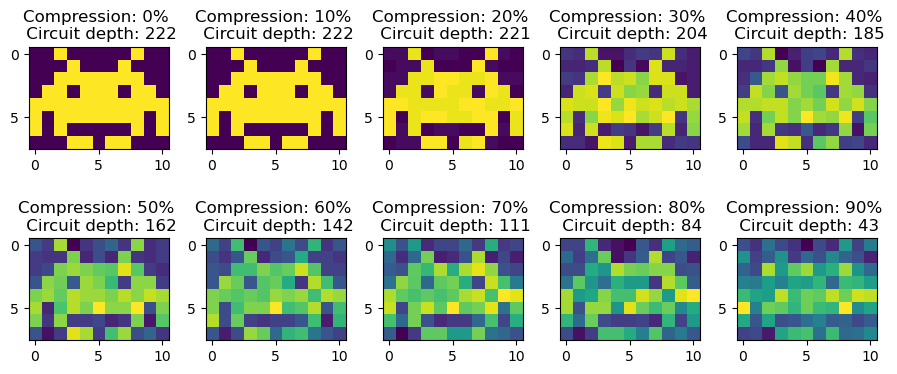

In [8]:
img = examples().space
shape = img.shape # save this for the reconstruction!


comp_images = []
labels = []
for i in range(0,110,10):
    comp_str = "Compression: "+str(i)+"% \n"
    qc = cFRQI(img,i)
    job = backend.run(qc)
    depth_str = " Circuit depth: "+str( qc.depth())
    #### Just for show
    sv = np.real(job.result().get_statevector())
    img2 = decodeQPIXL(sv)
    comp_images.append(reconstruct_img(img2, shape).T)
    labels.append(comp_str+depth_str)

fig = plt.figure(figsize=(9, 4))
columns = 5
rows = 2
for i in range(0, columns*rows ):
    img = comp_images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(labels[i])
plt.tight_layout()
plt.show()


# Quantum photoshop!
You can imagine that you can now do some quantum operation on this encoded state!!!
So what do a global rotation do to our image?

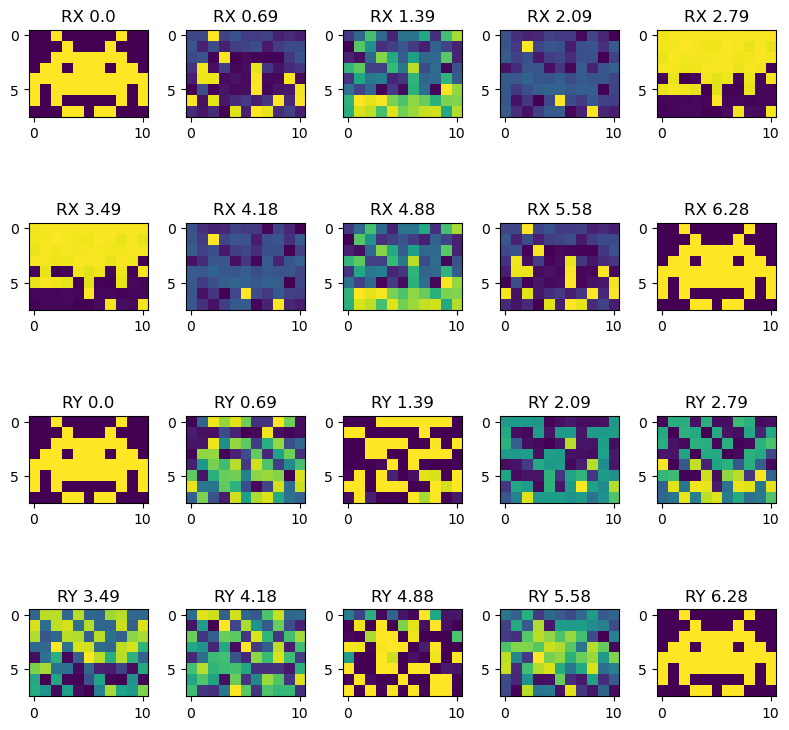

In [23]:
#### Single Picture 'Photoshop'
labels  = []
gen_mats = []
for i in np.linspace(0,2*np.pi,10):
    example = examples().space
    qc = cFRQI(example,0)
    qc.rx(i,range(qc.num_qubits)) ### apply RX to everything
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, shape).T
    labels.append('RX '+str(i)[0:4])
    gen_mats.append(example)

for i in np.linspace(0,2*np.pi,10):
    example = examples().space
    qc = cFRQI(example,0)
    qc.ry(i,range(qc.num_qubits)) ### apply RY to everything
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, shape).T
    labels.append('RY '+str(i)[0:4])
    gen_mats.append(example)

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 4
for i in range(0, columns*rows ):
    img = gen_mats[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(labels[i])
plt.tight_layout()
plt.show()



In [37]:
from ipywidgets import interact
def plot_interactiverot(ang, qubit, gate):
    example = examples().space
    qc = cFRQI(example,0)
    if gate == 'RY':
        qc.ry(ang,qubit) 
    if gate == 'RX':
        qc.rx(ang,qubit) ### apply RX to everything
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, shape).T
    plt.imshow(example)

gates = ['RY','RX']
interact(plot_interactiverot,ang=(0,np.pi,0.2),qubit=(0,7),gate=gates)


interactive(children=(FloatSlider(value=1.4000000000000001, description='ang', max=3.141592653589793, step=0.2…

<function __main__.plot_interactive(ang, qubit, gate)>

In [40]:
from ipywidgets import interact
def plot_interactivecnot(control, target):
    example = examples().space
    qc = cFRQI(example,0)
    if control != target:
        qc.cnot(control,target) ### apply RX to everything
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, shape).T
    plt.imshow(example)

interact(plot_interactivecnot,control=(0,7),target=(0,7))


interactive(children=(IntSlider(value=3, description='control', max=7), IntSlider(value=3, description='target…

<function __main__.plot_interactivecnot(control, target)>

In [10]:
def one_image_photoshop(backend, img,shape,comp=10, state_to_prob = np.real):
    """An example class for how you might do some 'quantum photshopping' with QPIXL

    Args:
        backend (qiskit quantum backend): A backend to simualte things, must output statevector or full probabilities
        img (np.array): array with image, can be flat or not
        shape (tuple): tuple with shape of image
        comp (int, optional): compress image, by what percentage. Defaults to 10.
        state_to_prob (function): how to cast your statevector to real values. Defaults to np.real.

    Returns:
        image: processed image
    """
    test = pad_0(img)
    test = convertToAngles(test)
    qc = cFRQI(test,10)
    ### INSERT DESIRED GATES HERE
    for i in range(1):
        qc.cnot(i,i+10)
    #################
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    img = decodeQPIXL(sv, state_to_prob = state_to_prob)
    img = reconstruct_img(img, shape)
    return img


def two_image_comb(backend, img1,img2,shape,comp=10,state_to_prob = np.abs):
    """An example class for how you might do some 'quantum photshopping' with QPIXL
    this can combine two images! You should change the gates in the playzone in the middle

    Args:
        backend (qiskit quantum backend): A backend to simualte things, must output statevector or full probabilities
        img1 (np.array): array with image 1, can be flat or not
        img2 (np.array): array with image 1, can be flat or not
        shape (tuple): tuple with shape of image
        comp (int, optional): compress image, by what percentage. Defaults to 10.
        state_to_prob (function): how to cast your statevector to real values. Defaults to np.real.

    Returns:
        image: processed image
    """

    img1 = convertToAngles(pad_0(img1))
    img2 = convertToAngles(pad_0(img2))
    qc1 = cFRQI(img1,comp)
    qc2 = cFRQI(img2,comp)
    big_qc = QuantumCircuit(qc1.width()+qc2.width())
    big_qc = big_qc.compose(qc1, qubits=list(range(qc1.width())))
    big_qc = big_qc.compose(qc2, qubits=list(range(qc1.width(),qc1.width()*2)))
    ### INSERT DESIRED GATES HERE
    big_qc.x(range(11,22))
    for i in range(11):
        big_qc.cnot(i, i+qc1.width())
        # Example of CNOT between two images
    #########################
    job = backend.run(big_qc)
    sv = np.real(job.result().get_statevector())
    img = decodeQPIXL(sv, state_to_prob = state_to_prob)#Image 1 is the one that is recovered
    img = reconstruct_img(img, shape)
    return img
